Завантаження та підготовка даних

In [3]:
pip install chronos-forecasting

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from chronos import BaseChronosPipeline


df = pd.read_csv("electricity_consumption_and_production.csv", parse_dates=['DateTime'])
df['Date'] = df['DateTime'].dt.date
daily_df = df.groupby('Date')['Consumption'].sum().reset_index()
daily_df['Date'] = pd.to_datetime(daily_df['Date'])
daily_df = daily_df.drop_duplicates(subset='Date').set_index('Date')
full_range = pd.date_range(daily_df.index.min(), daily_df.index.max(), freq='D')
daily_df = daily_df.reindex(full_range)
daily_df['Consumption'] = daily_df['Consumption'].interpolate()

Сезонність і тренд

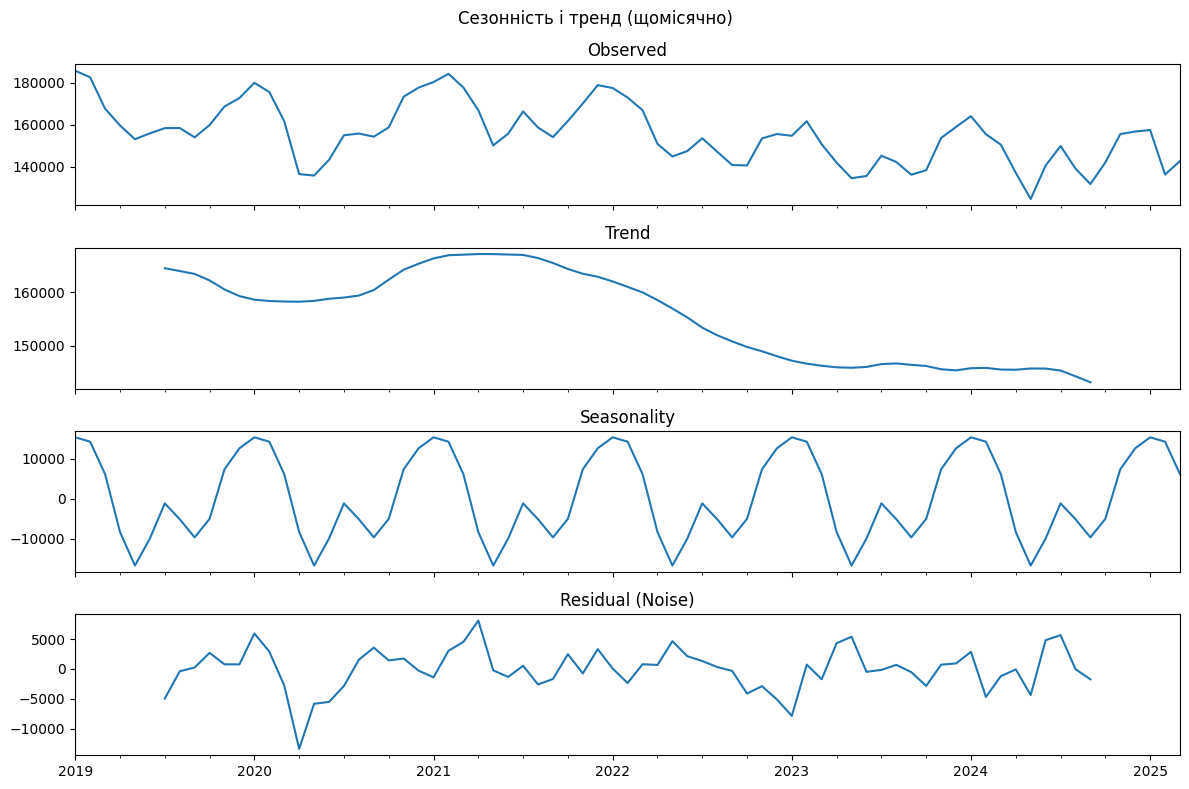

In [5]:
monthly = daily_df.resample('ME').mean()
decomposition = seasonal_decompose(monthly, model='additive', period=12)
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonality')
decomposition.resid.plot(ax=axes[3], title='Residual (Noise)')
plt.suptitle("Сезонність і тренд (щомісячно)")
plt.tight_layout()
plt.show()

Утиліти

In [6]:
forecast_horizons = [15, 30, 45]
results = []

def calculate_metrics(test_series: pd.Series, forecast_series: pd.Series):
    mape = mean_absolute_percentage_error(test_series, forecast_series)
    mae = mean_absolute_error(test_series, forecast_series)
    mse = mean_squared_error(test_series, forecast_series)
    return mape, mae, mse

def visualize_forecast(train_series: pd.Series, test_series: pd.Series, forecast_series: pd.Series, title: str):
    mape, mae, mse = calculate_metrics(test_series, forecast_series)
    fig, ax = plt.subplots(figsize=(14, 6))
    train_series.plot(ax=ax, label="Train series")
    test_series.plot(ax=ax, label="Test series")
    forecast_series.plot(ax=ax, label="Predicted series")
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Electricity Consumption")
    ax.legend()
    ax.grid(True)
    metrics_text = f"MAPE: {mape*100:.2f}%\nMAE: {mae:.2f}\nMSE: {mse:.2f}"
    ax.text(0.99, 0.95, metrics_text, transform=ax.transAxes,
            fontsize=12, verticalalignment='top', horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=1'))
    plt.tight_layout()
    plt.show()

def create_lags(series, n_lags, horizon):
    X, y = [], []
    for i in range(n_lags, len(series)-horizon):
        X.append(series[i-n_lags:i])
        y.append(series[i+horizon])
    return np.array(X), np.array(y)

def log_and_visualize(name, h, train_series, test_series, forecast_series):
    mape, mae, mse = calculate_metrics(test_series, forecast_series)
    results.append({
        "Model": name,
        "Horizon": h,
        "MAPE": round(mape * 100, 2),
        "MAE": round(mae, 2),
        "MSE": round(mse, 2)
    })
    visualize_forecast(train_series, test_series, forecast_series, f"{name} forecast ({h} days)")


SARIMAX

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


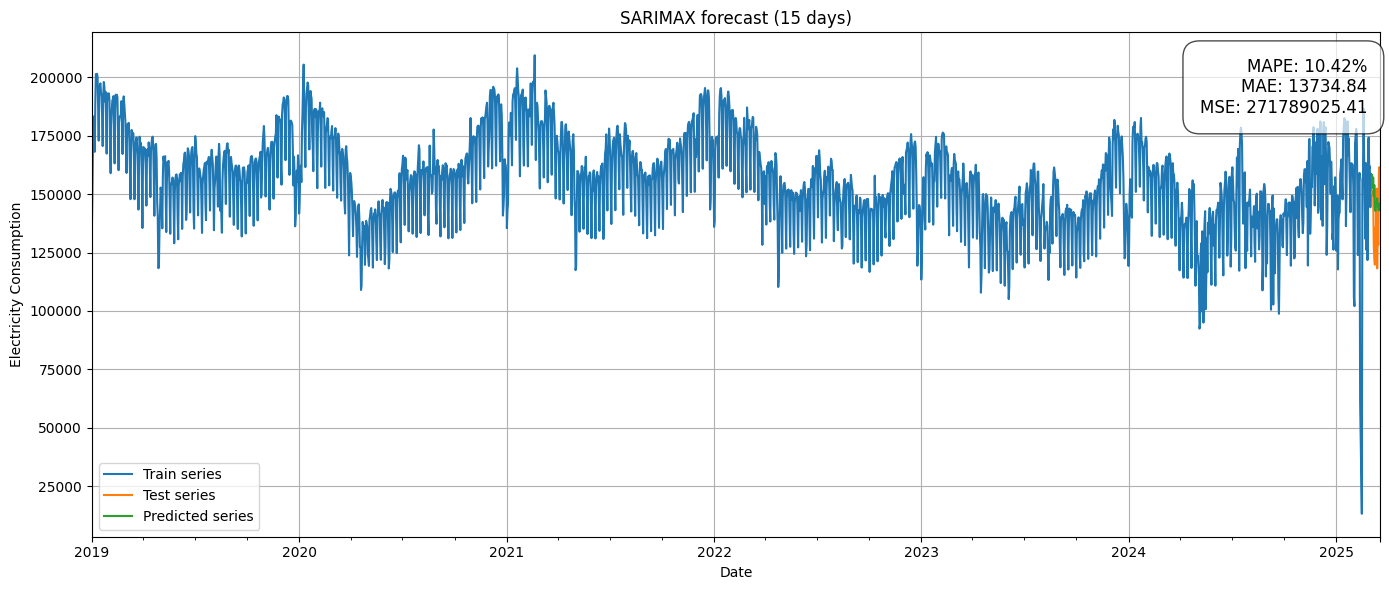

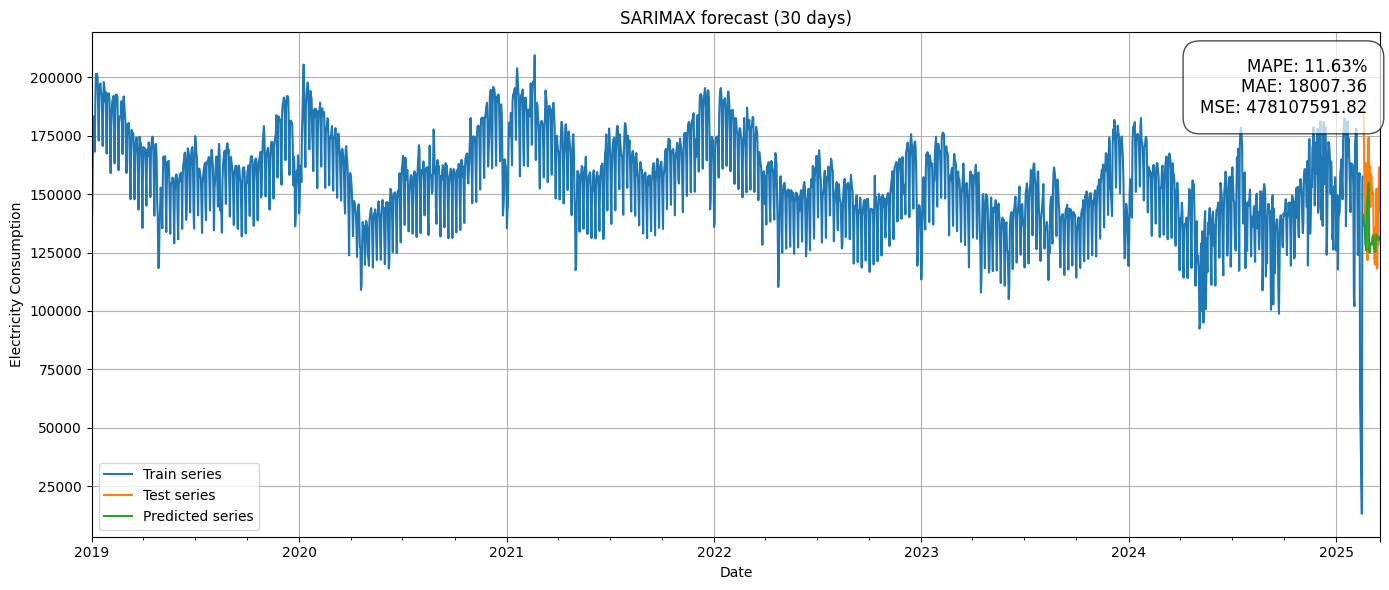

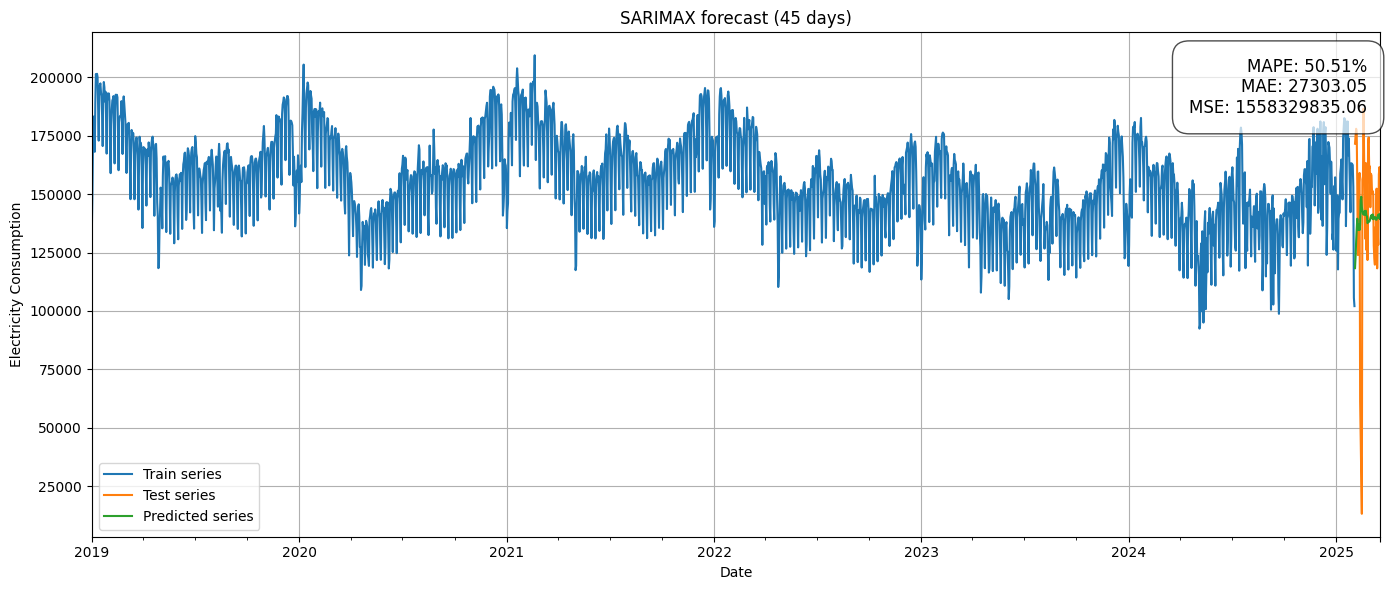

In [7]:
for h in forecast_horizons:
    train = daily_df[:-h]
    test = daily_df[-h:]
    model = SARIMAX(train['Consumption'], order=(1,1,1), seasonal_order=(1,1,1,12))
    fitted = model.fit(disp=False)
    forecast = pd.Series(fitted.forecast(h), index=test.index)
    log_and_visualize("SARIMAX", h, train['Consumption'], test['Consumption'], forecast)



Prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyhsapy14/pvlrp6nd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyhsapy14/pw9xw4lv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44169', 'data', 'file=/tmp/tmpyhsapy14/pvlrp6nd.json', 'init=/tmp/tmpyhsapy14/pw9xw4lv.json', 'output', 'file=/tmp/tmpyhsapy14/prophet_modelhq_leg3e/prophet_model-20250623062702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:27:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


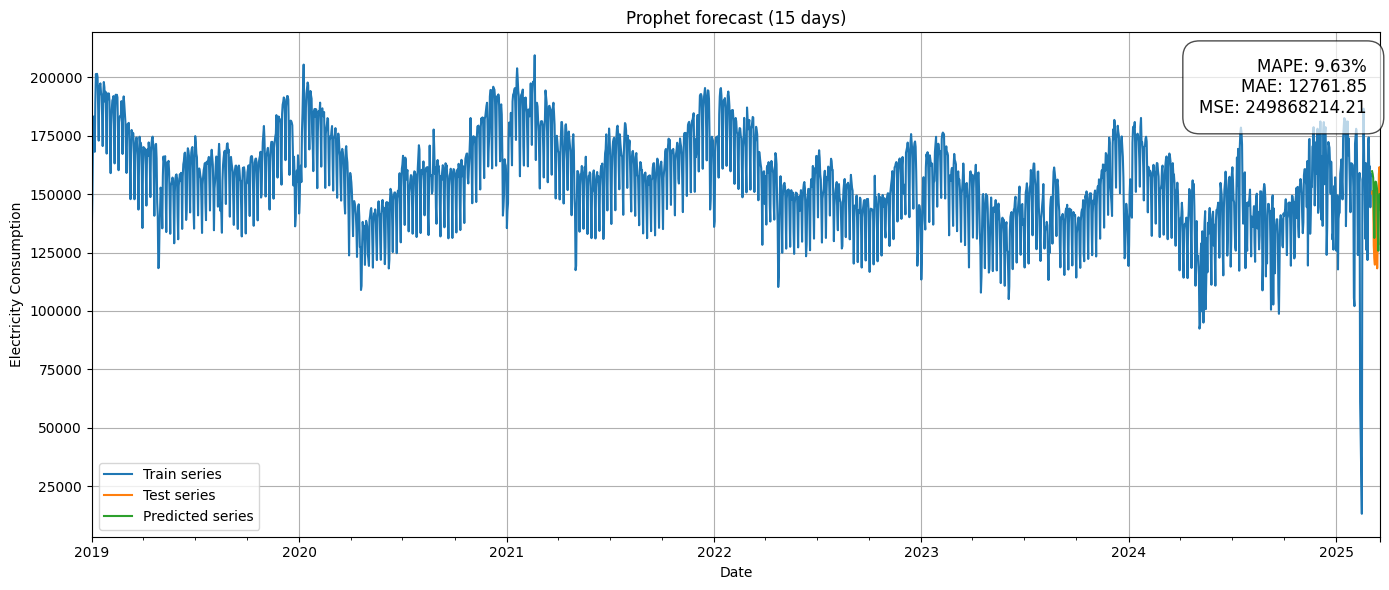

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyhsapy14/t7y3g424.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyhsapy14/0lz2gf0m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89660', 'data', 'file=/tmp/tmpyhsapy14/t7y3g424.json', 'init=/tmp/tmpyhsapy14/0lz2gf0m.json', 'output', 'file=/tmp/tmpyhsapy14/prophet_modelo0srtngc/prophet_model-20250623062703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:27:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


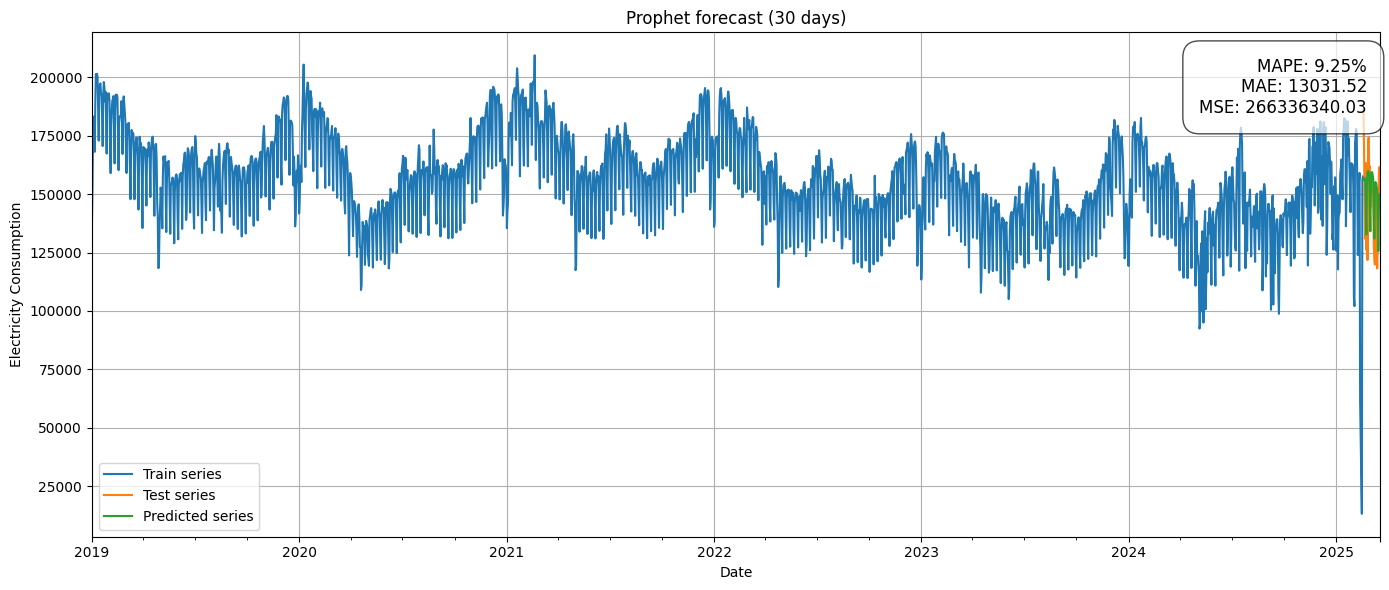

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyhsapy14/pazhvkm9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyhsapy14/8mu1roqh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61864', 'data', 'file=/tmp/tmpyhsapy14/pazhvkm9.json', 'init=/tmp/tmpyhsapy14/8mu1roqh.json', 'output', 'file=/tmp/tmpyhsapy14/prophet_model3i1ya5fm/prophet_model-20250623062705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:27:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


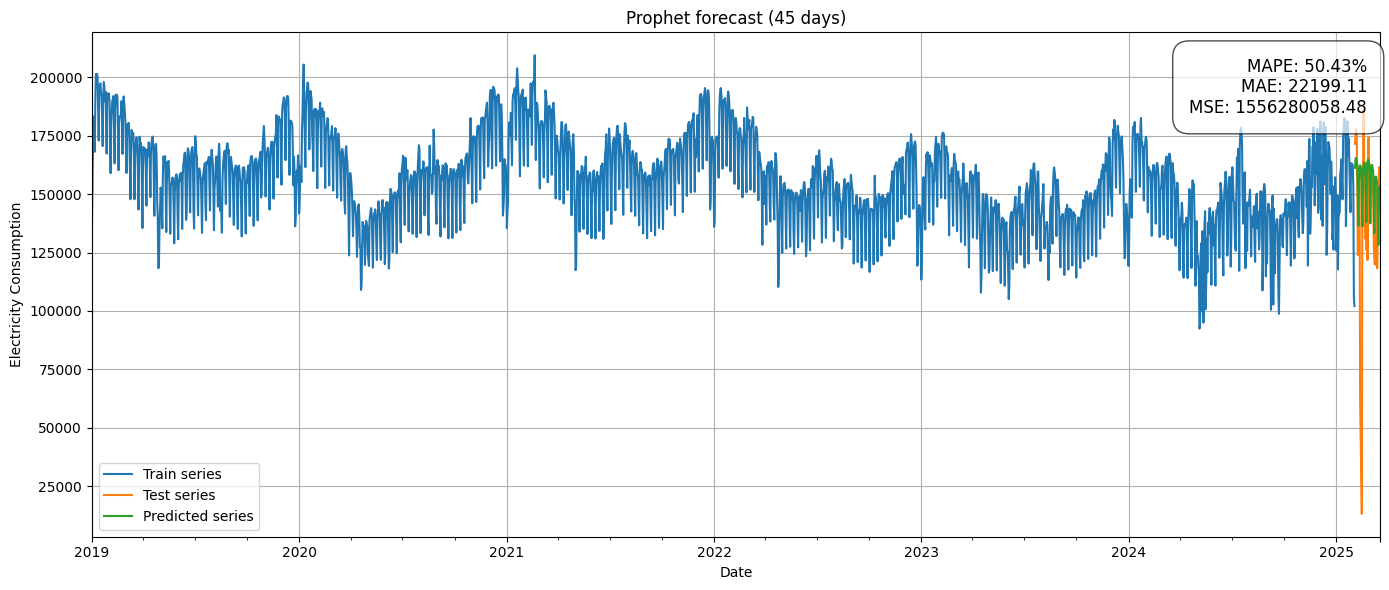

In [8]:
df_prophet = daily_df.reset_index().rename(columns={"index": "ds", "Consumption": "y"})
for h in forecast_horizons:
    train_df = df_prophet[:-h]
    test_df = df_prophet[-h:]
    model = Prophet()
    model.fit(train_df)
    future = model.make_future_dataframe(h)
    forecast = model.predict(future)
    forecast_series = pd.Series(forecast['yhat'].values[-h:], index=test_df['ds'])
    log_and_visualize("Prophet", h,
        train_df.set_index('ds')['y'],
        test_df.set_index('ds')['y'],
        forecast_series)

Time-Lagged Regression

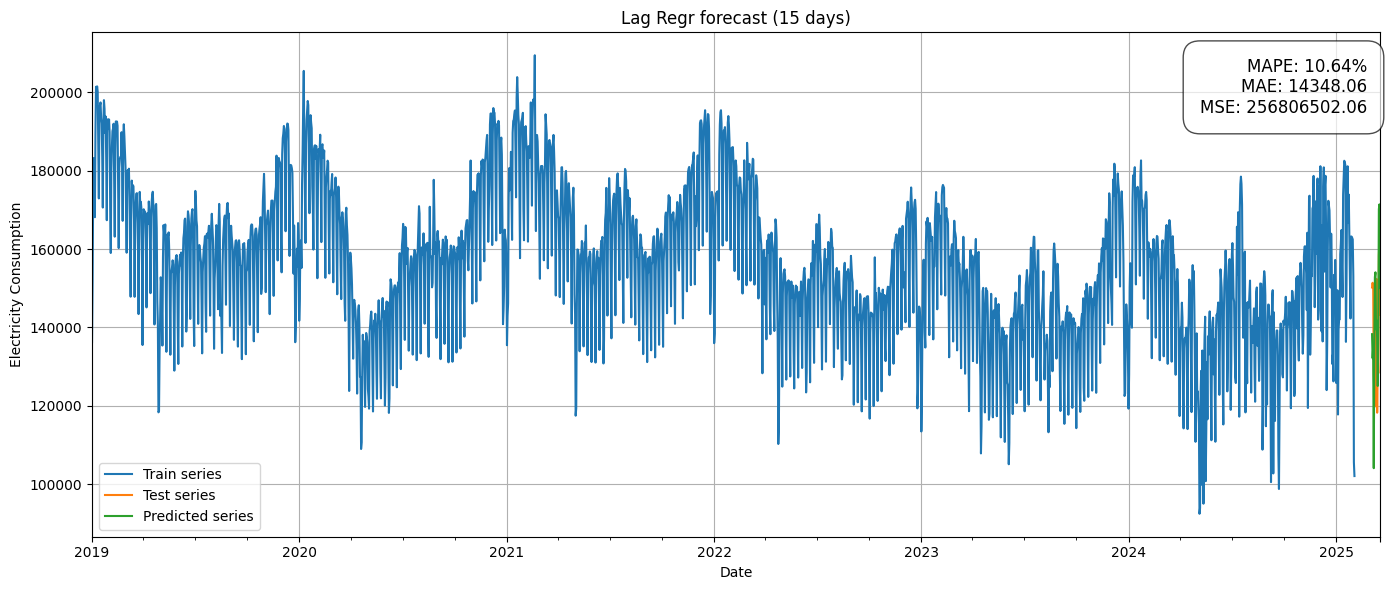

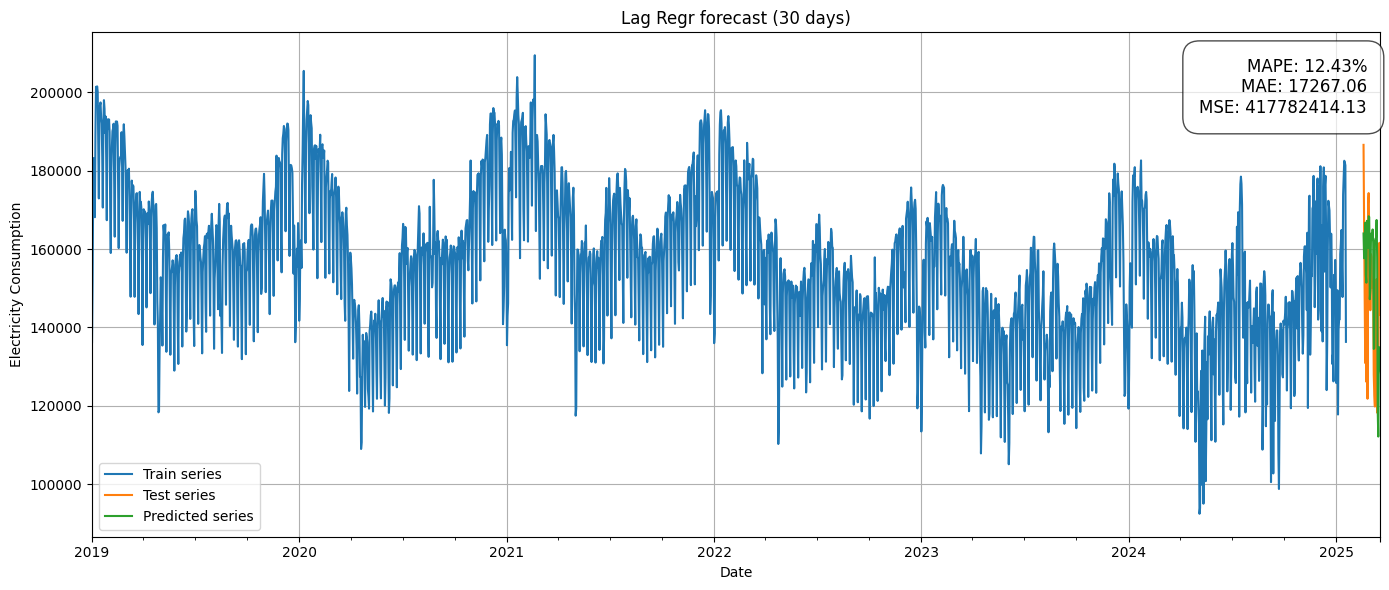

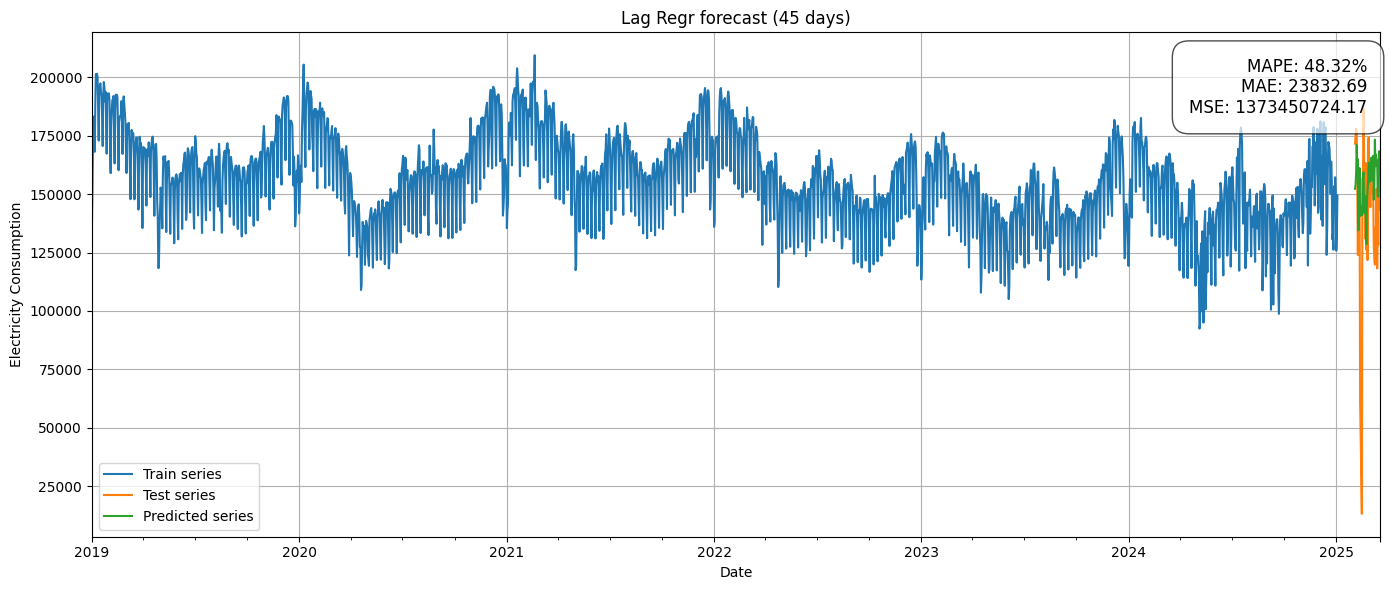

In [9]:
for h in forecast_horizons:
    series = daily_df['Consumption'].values
    X, y = create_lags(series, 30, h)
    model = LinearRegression().fit(X, y)
    pred = model.predict(X[-h:])
    forecast_series = pd.Series(pred, index=daily_df.index[-h:])
    train_series = pd.Series(series[:-(h+30)], index=daily_df.index[:-(h+30)])
    test_series = pd.Series(y[-h:], index=daily_df.index[-h:])
    log_and_visualize("Lag Regr", h, train_series, test_series, forecast_series)


Chronos-Bolt

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/821M [00:00<?, ?B/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


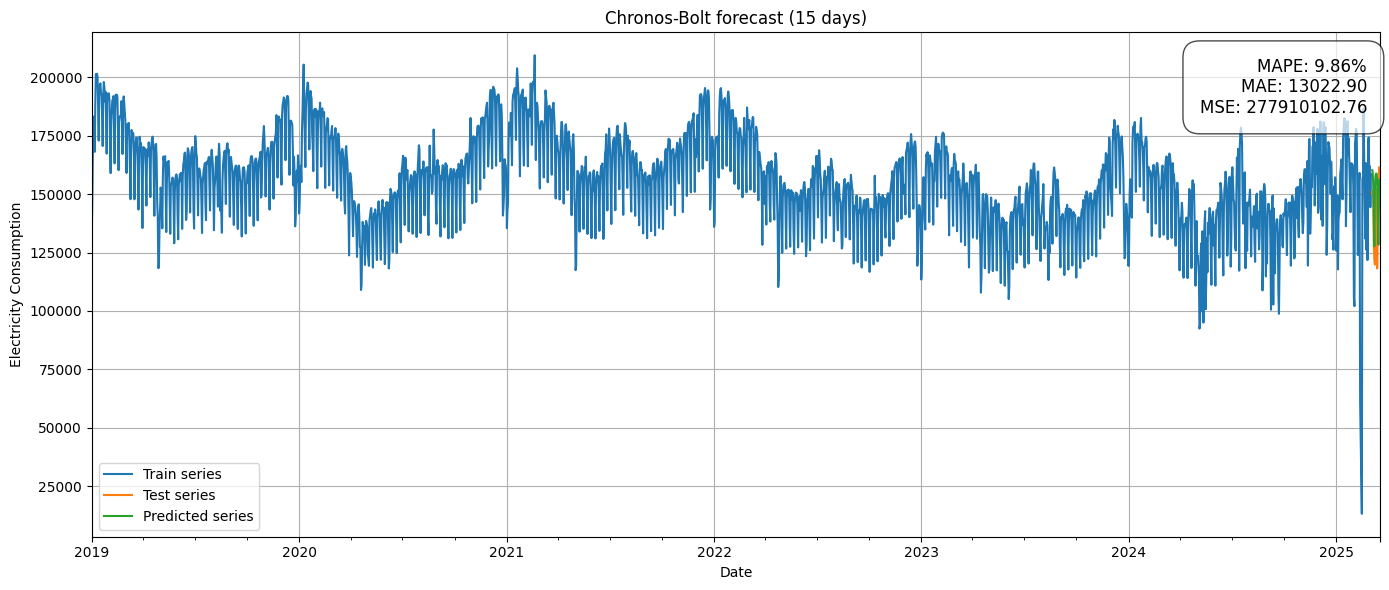

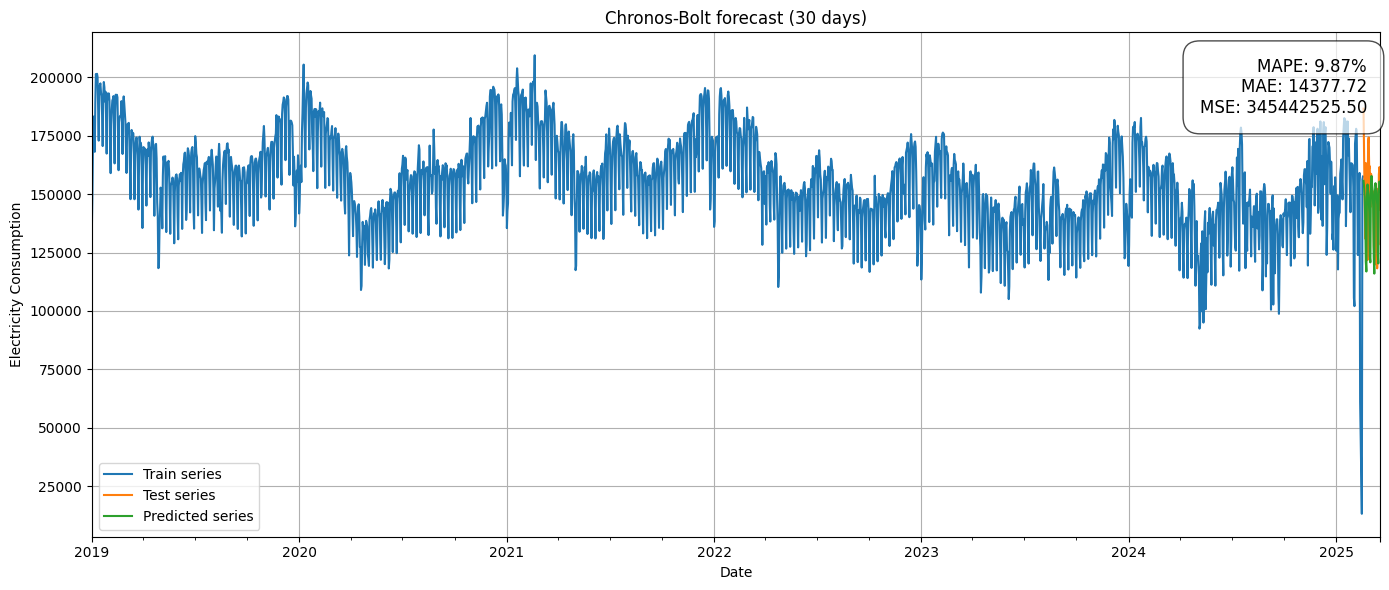

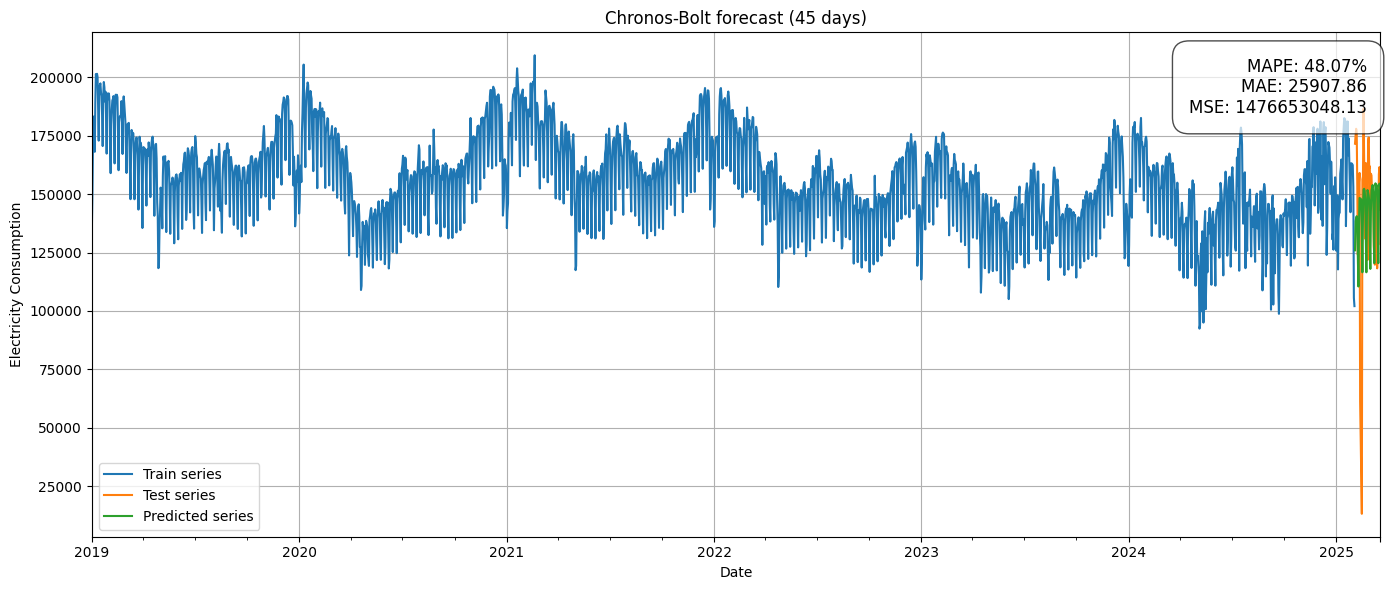

In [10]:
for h in forecast_horizons:
    series = daily_df['Consumption']
    full_values = series.values
    train_values = full_values[:-(h)]
    test_values = full_values[-h:]
    train_index = series.index[:-(h)]
    test_index = series.index[-h:]
    chronos_model = BaseChronosPipeline.from_pretrained(
        "amazon/chronos-bolt-base",
        device_map="cpu",
        torch_dtype=torch.bfloat16,
    )
    train_tensor = torch.tensor(train_values, dtype=torch.float32)
    forecast = chronos_model.predict_quantiles(
        context=train_tensor,
        prediction_length=h
    )
    mean_forecast = forecast[1][0].tolist()
    forecast_series = pd.Series(mean_forecast, index=test_index)
    train_series = pd.Series(train_values, index=train_index)
    test_series = pd.Series(test_values, index=test_index)
    log_and_visualize("Chronos-Bolt", h, train_series, test_series, forecast_series)


In [11]:
metrics_df = pd.DataFrame(results)

for h in forecast_horizons:
    print(f"\n Таблиця метрик для прогнозу на {h} днів:")
    display_df = metrics_df[metrics_df["Horizon"] == h].set_index("Model")[["MAPE", "MAE", "MSE"]]
    print(display_df)


 Таблиця метрик для прогнозу на 15 днів:
               MAPE       MAE           MSE
Model                                      
SARIMAX       10.42  13734.84  2.717890e+08
Prophet        9.63  12761.85  2.498682e+08
Lag Regr      10.64  14348.06  2.568065e+08
Chronos-Bolt   9.86  13022.90  2.779101e+08

 Таблиця метрик для прогнозу на 30 днів:
               MAPE       MAE           MSE
Model                                      
SARIMAX       11.63  18007.36  4.781076e+08
Prophet        9.25  13031.52  2.663363e+08
Lag Regr      12.43  17267.06  4.177824e+08
Chronos-Bolt   9.87  14377.72  3.454425e+08

 Таблиця метрик для прогнозу на 45 днів:
               MAPE       MAE           MSE
Model                                      
SARIMAX       50.51  27303.05  1.558330e+09
Prophet       50.43  22199.11  1.556280e+09
Lag Regr      48.32  23832.69  1.373451e+09
Chronos-Bolt  48.07  25907.86  1.476653e+09


  Згідно з отриманими результатами для трьох періодів прогнозу — 15, 30 і 45 днів найкращою моделлю для прогнозування на короткі періоди 15 і 30 днів є Prophet за найнижчими показниками MAPE i MAE, на довгий період краще себе показала модель - Chronos-Bolt.
  
  Щодо швидкості навчання та прогнозу то найшвидша модель - Time-Lagged Regression, за нею йде Prophet.
  

  Отже, Prophet є найефективнішою моделлю для цього набору даних, якщо враховувати точність прогнозів на коротких і середніх відрізках, а також швидкість навчання. Chronos-Bolt можна розглядати як альтернативу для довгострокових прогнозів.

